In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import importlib
import helpers
importlib.reload(helpers)  
from helpers import plot_measurement_distribution

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

* Exploratory Data Analysis

In [ ]:
df = pd.read_csv('continuous_factory_process.csv')

# Convert time_stamp to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
duration = df['time_stamp'].max() - df['time_stamp'].min()
duration_hours = duration.total_seconds() / 3600

print(f"Data shape: {df.shape}")
print(f"Number of columns: {len(df.columns)}")
print(f"Time span: {df['time_stamp'].min()} to {df['time_stamp'].max()}")
print(f"Duration: {duration_hours:.2f} hours ({duration_hours * 60:.0f} minutes)")
print(f"Sampling rate: ~{len(df) / (duration_hours * 3600):.2f} Hz (should be ~1 Hz)")
print(f"\nMissing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")
print(f"\nFirst few rows:")
df.head(5)

# Group variables by machine/stage for organized visualization
machine1_cols = [col for col in df.columns if 'Machine1' in col]
machine2_cols = [col for col in df.columns if 'Machine2' in col]
machine3_cols = [col for col in df.columns if 'Machine3' in col]
combiner_cols = [col for col in df.columns if 'Combiner' in col or 'combiner' in col.lower()]
machine4_cols = [col for col in df.columns if 'Machine4' in col]
machine5_cols = [col for col in df.columns if 'Machine5' in col]
primary_output_cols = [col for col in df.columns if 'Primary' in col]
secondary_output_cols = [col for col in df.columns if 'Secondary' in col]
ambient_cols = [col for col in df.columns if 'Ambient' in col]


print(f"Ambient conditions: {len(ambient_cols)}")
print(f"Stage 1 - Machine 1: {len(machine1_cols)}")
print(f"Stage 1 - Machine 2: {len(machine2_cols)}")
print(f"Stage 1 - Machine 3: {len(machine3_cols)}")
print(f"Combiner: {len(combiner_cols)}")
print(f"Stage 2 - Machine 4: {len(machine4_cols)}")
print(f"Stage 2 - Machine 5: {len(machine5_cols)}")
print(f"Primary outputs (Stage 1): {len(primary_output_cols)}")
print(f"Secondary outputs (Stage 2): {len(secondary_output_cols)}")
print(f"\nTotal: {len(ambient_cols) + len(machine1_cols) + len(machine2_cols) + len(machine3_cols) + len(combiner_cols) + len(machine4_cols) + len(machine5_cols) + len(primary_output_cols) + len(secondary_output_cols)} variables")

In [ ]:
# Visualize PRIMARY OUTPUTS (15 measurements after Stage 1) - Main prediction targets
# Based on notes: columns 42-71 are primary outputs (15 measurements × 2 = 30 columns: Actual + Setpoint)

primary_cols = df.columns[42:72].tolist()
print(f"Primary output columns (42-71): {len(primary_cols)}")
print(f"Sample columns: {primary_cols[:5]}")

# Plot primary outputs in grid (5 columns per row)
n_primary = len(primary_cols)
cols_per_row = 5
n_rows = (n_primary + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 4*n_rows))
fig.suptitle('Primary Outputs (Stage 1 Measurements) - Target Variables for Prediction', fontsize=14)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, col in enumerate(primary_cols):
    ax = axes[idx]
    ax.plot(df['time_stamp'], df[col], linewidth=0.8, alpha=0.8)
    ax.set_title(col, fontsize=8, pad=2)
    ax.set_xlabel('Time', fontsize=6)
    ax.set_ylabel('Value', fontsize=6)
    ax.tick_params(labelsize=6)
    ax.grid(True, alpha=0.3)

# clean format - hide unused sub plots
for idx in range(len(primary_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Separate Actual and Setpoint columns + Count zeros
actual_cols = [col for col in primary_cols if '.Actual' in col]
setpoint_cols = [col for col in primary_cols if '.Setpoint' in col]
zero_counts_actual = df[actual_cols].eq(0).sum()
zero_counts_setpoint = df[setpoint_cols].eq(0).sum()

print(f"\nZero counts in Actual measurements:")
print(zero_counts_actual[zero_counts_actual > 0].sort_values(ascending=False))

print(f"\nZero counts in Setpoint measurements:")
print(zero_counts_setpoint[zero_counts_setpoint > 0])

# Find rows where ALL outputs are zero (sensor reset events)
all_zero_mask = df[primary_cols].eq(0).all(axis=1)
reset_events = df[all_zero_mask]
print(f"Total rows with ANY zero value: {df[primary_cols].eq(0).any(axis=1).sum()}")
print(f"Rows where ALL outputs are zero (sensor resets): {len(reset_events)}")
print(f"Percentage of data affected: {len(reset_events) / len(df) * 100:.2f}%")

if len(reset_events) > 0:
    print(f"\nSensor reset event timestamps:")
    print(reset_events[['time_stamp']].head(20))
    print(f"\nTime range of reset events:")
    print(f"  First reset: {reset_events['time_stamp'].min()}")
    print(f"  Last reset: {reset_events['time_stamp'].max()}")

Observations:
- Setpoints drop significantly. For ML model, add indicator and potentially impute vals 
    - in principle, setpoints most likely should not change
- actual output is extremely messy

EXPLORATION OF ACTUAL MEASUREMENTS

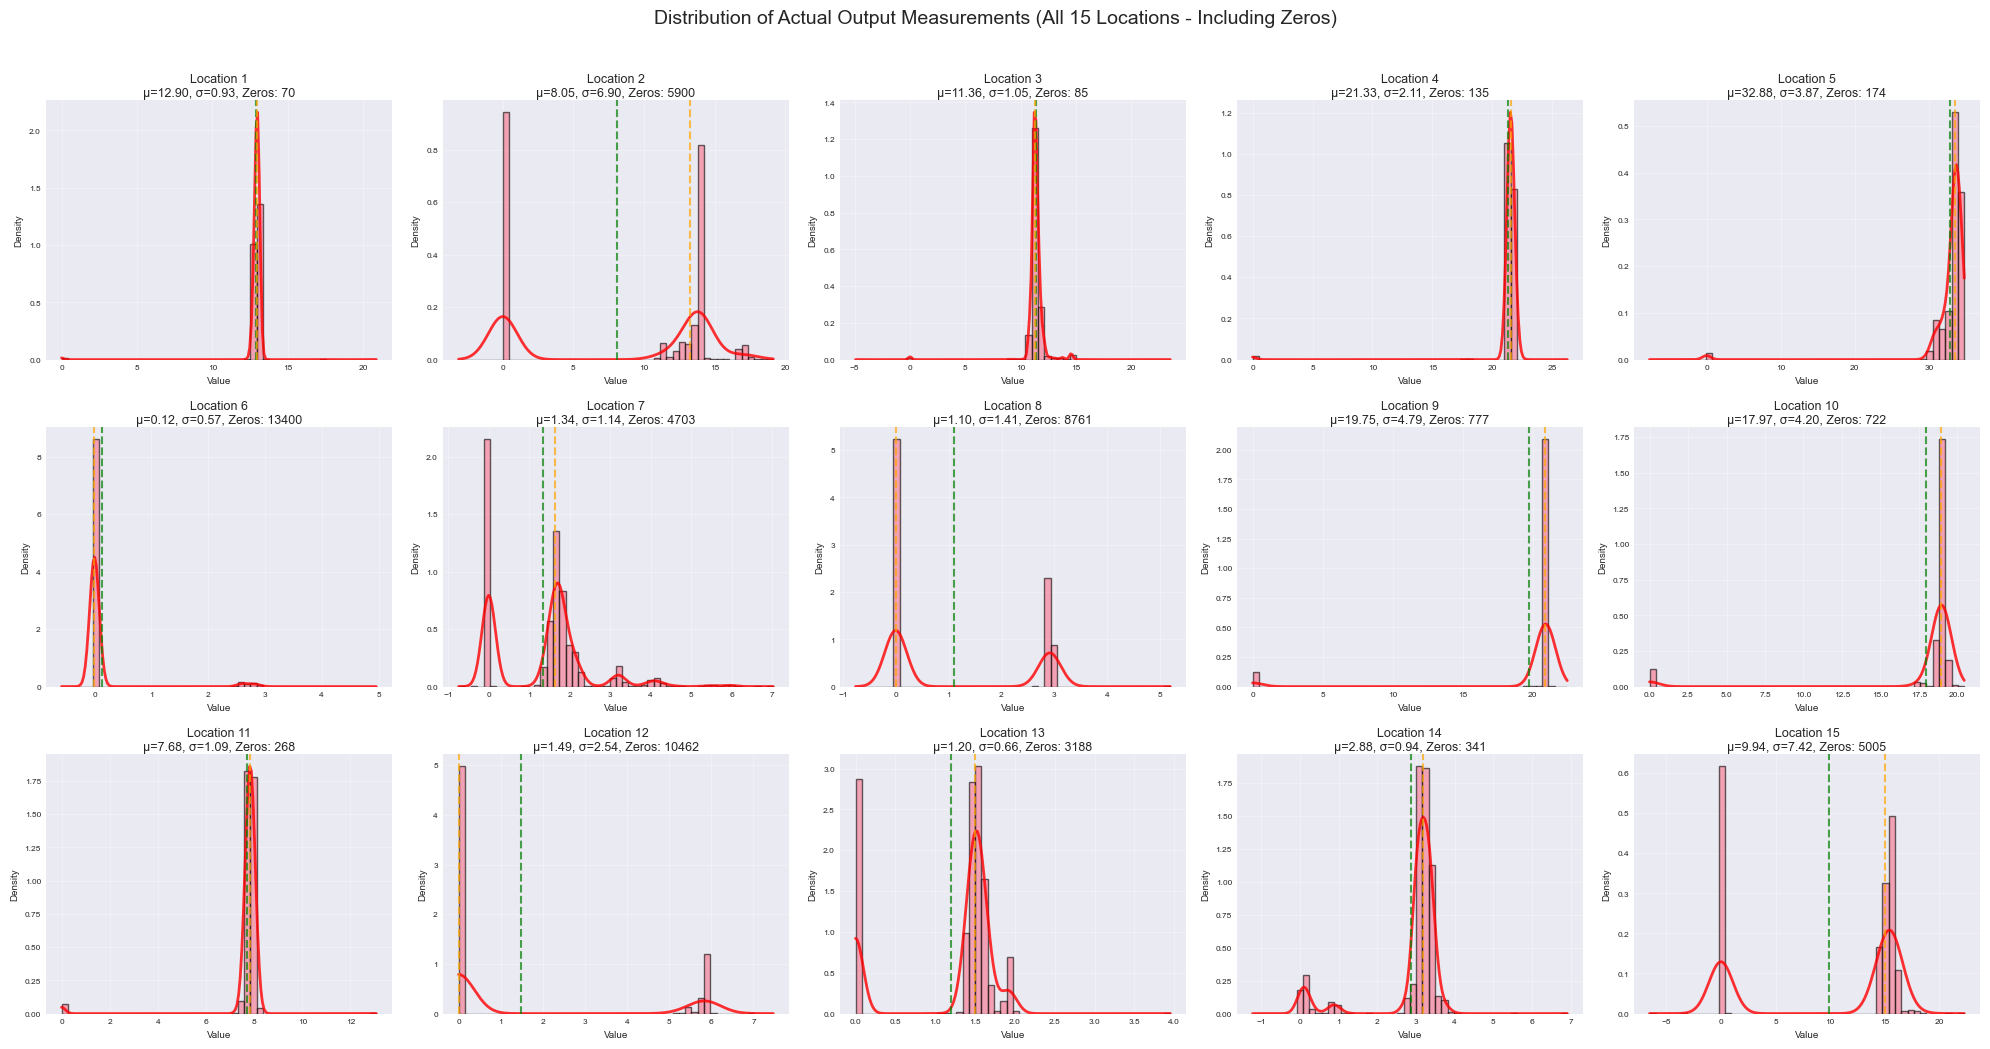

In [11]:
# Get primary output columns and separate Actual measurements
cols_per_row = 5
n_rows = (len(actual_cols) + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 3.5*n_rows))
fig.suptitle('Distribution of Actual Output Measurements (All 15 Locations - Including Zeros)', 
             fontsize=14, y=0.995)

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Loop through all actual measurements using helper function
for idx, col in enumerate(actual_cols):
    ax = axes[idx]
    plot_measurement_distribution(col, df, ax, exclude_zeros=False)

# Hide unused subplots
for idx in range(len(actual_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust for title, reduce white space
plt.show()